In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import yaml
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter


import pickle
import os
import time

from utils.generate_data import *
from utils.sub_sampler import *
from utils.compute_barycenter import *
from utils.general_utils import *

data_path = 'data'

### Paper's Gaussian mixture experiment

In [80]:
config_path = os.path.join('config', 'experience_1.yaml')
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader) 

folder_path = os.path.join(data_path, config['general']['folder_name'])
input_folder = os.path.join(folder_path, 'input')
sampling_folder = os.path.join(folder_path, 'sub-sampling')
results_folder = os.path.join(folder_path, 'results')

In [81]:
npart = 5
file_path_sol = os.path.join(results_folder, f'xsol_k{npart}.pkl')
file_path_support = os.path.join(results_folder, f'support_k{npart}.pkl')

with open(file_path_sol, 'rb') as file:
    xsol = pickle.load(file)
with open(file_path_support, 'rb') as file:
    overallPost = pickle.load(file)

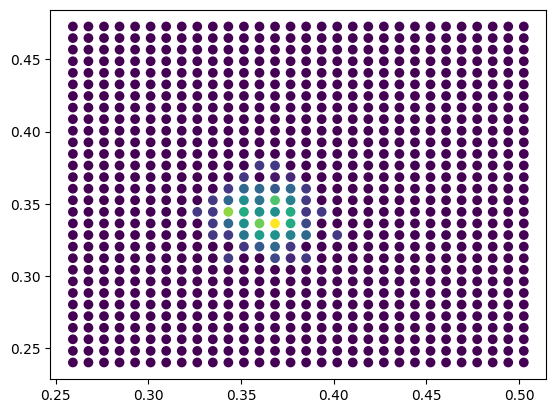

In [82]:
plt.scatter(overallPost[:, 0], overallPost[:, 1], c=xsol[:30*30])

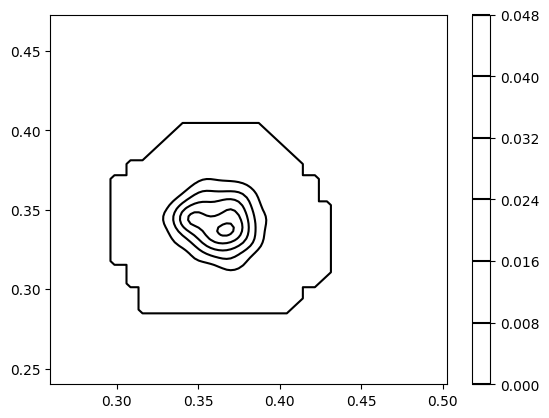

In [83]:
x, y = overallPost[:, 0], overallPost[:, 1]
z = xsol[:30*30]  # Your density or value for each point

# Create grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on this grid
zi = griddata((x, y), z, (xi, yi), method='linear')
zi = gaussian_filter(zi, sigma=2)

# Plot
plt.contour(xi, yi, zi, levels=5, colors='black')  # Adjust levels as needed
plt.colorbar()  # Show color scale
plt.show()

In [84]:
filename = os.path.join(sampling_folder, f"full_dataset.pkl")

with open(filename, 'rb') as file:
    full_data_sampling = pickle.load(file)

In [85]:
def f(m):
    eps = 10e-3
    # Extract the elements of the covariance matrices
    sigma_0_0 = m['cov'][:, 0, 0, 0]  # Covariance matrix 1, element (0, 0)
    sigma_0_1 = m['cov'][:, 0, 0, 1]  # Covariance matrix 1, element (0, 1) = (1, 0)
    sigma_1_1 = m['cov'][:, 0, 1, 1]  # Covariance matrix 1, element (1, 1)
    sigma_2_0 = m['cov'][:, 1, 0, 0]  # Covariance matrix 2, element (0, 0)
    sigma_2_1 = m['cov'][:, 1, 0, 1]  # Covariance matrix 2, element (0, 1) = (1, 0)
    sigma_3_1 = m['cov'][:, 1, 1, 1]  # Covariance matrix 2, element (1, 1)

    # Compute correlation coefficients
    corr1 = sigma_0_1 / np.sqrt(np.maximum(eps, sigma_0_0 * sigma_1_1))
    corr2 = sigma_2_1 / np.sqrt(np.maximum(eps, sigma_2_0 * sigma_3_1))

    # Combine the results
    return np.stack((corr1, corr2), axis=-1)

In [86]:
x_sub_sampling = []
for i in range(5):
    filename = os.path.join(sampling_folder, f"sample_{i}.pkl")
    with open(filename, 'rb') as file:
        x_sub_sampling.append(pickle.load(file))

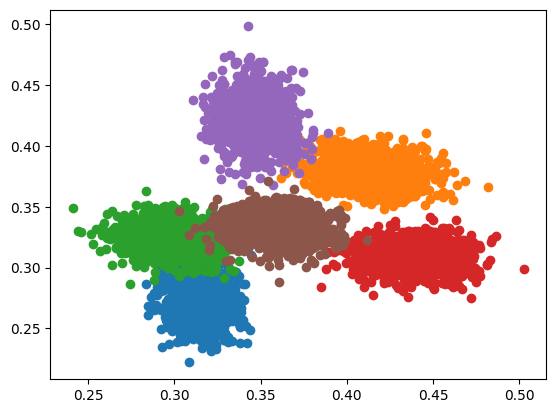

In [87]:
for sub_sampling in x_sub_sampling:
    f_m = f(sub_sampling)
    plt.scatter(f_m[:, 0], f_m[:, 1])

f_m = f(full_data_sampling)
plt.scatter(f_m[:, 0], f_m[:, 1])

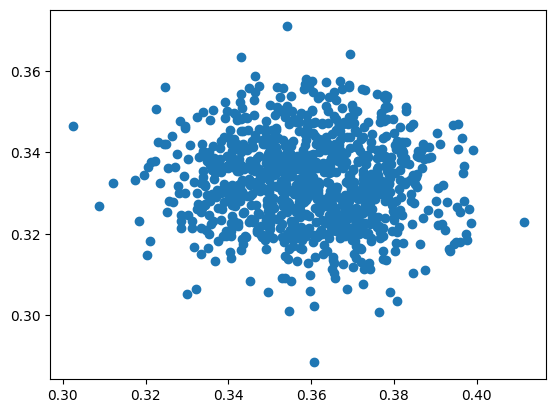

In [88]:
f_m = f(full_data_sampling)
plt.scatter(f_m[:, 0], f_m[:, 1])

In [89]:
def smooth_equidensity_line(x, y):
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Create a grid to evaluate KDE
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid_points = np.vstack([xx.ravel(), yy.ravel()])
    zz = gaussian_kde(xy)(grid_points).reshape(xx.shape)

    return xx, yy, zz

Text(0, 0.5, 'Feature 2')

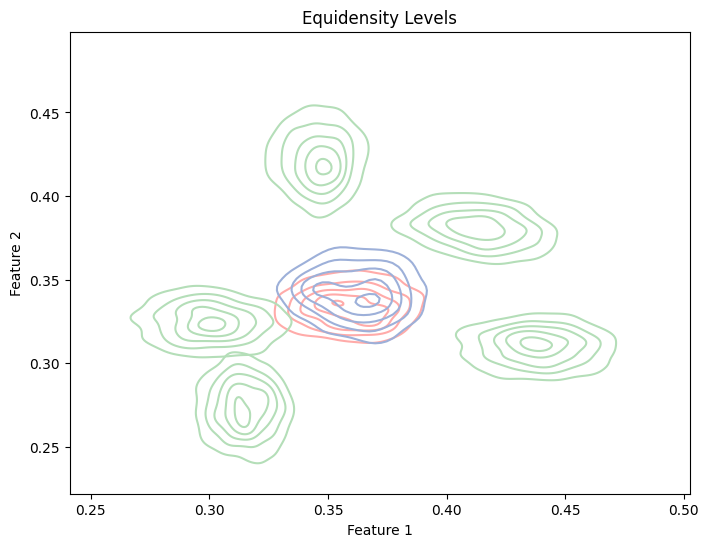

In [105]:
plt.figure(figsize=(8, 6))

f_m = f(full_data_sampling)
x = f_m[:, 0]
y = f_m[:, 1]
xx, yy, zz = smooth_equidensity_line(x, y)
plt.contour(xx, yy, zz, levels=5, colors='#ffaba9')  # contour lines

for sub_sampling in x_sub_sampling:
    f_m = f(sub_sampling)
    x = f_m[:, 0]
    y = f_m[:, 1]
    xx, yy, zz = smooth_equidensity_line(x, y)
    plt.contour(xx, yy, zz, levels=5, colors='#b4deb8')

x, y = overallPost[:, 0], overallPost[:, 1]
z = xsol[:30*30]  # Your density or value for each point

# Create grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on this grid
zi = griddata((x, y), z, (xi, yi), method='linear')
zi = gaussian_filter(zi, sigma=2) + 10e-8

# Plot
plt.contour(xi, yi, zi, levels=5, colors='#9db0d9')  # Adjust levels as needed

plt.title('Equidensity Levels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')